In [1]:
import numpy as np
import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from random import random, randint, sample
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import os
import time
import tkinter as tk
import torch
#initialize for random seeds/states
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
rng = np.random.default_rng(12345)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
class paper_game(ABC):
    def __init__(self, start_state):
        self.state=start_state
    
    @abstractmethod
    def transition(state, action, player):
        #return next state
        pass
    


In [3]:
class connect4(paper_game):
    #state: 6x7 array to represent board config, with 1 representing self-checker, -1 representing opponent-checker, 0 representing empty
    def __init__(self, start_state=np.zeros((6,7), dtype=np.int8), epsilon=0.9, alpha=0.5, gamma=0.8):
        self.first_state = self.state = start_state
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player_turn = 1
        self.turn_count = 0
        self.Q = None
        #self.Q = np.zeros((19683, 9)) - need to change to Q-network somewhere
        
    def transition(self, state, action, player):
        #action: a list/tuple of row and column index to indicate which cell is chosen
        #player: 1 or -1, with 1 being self-checker, -1 being opponent-checker
        #applicable to both tic_tac_toe and Connect-4
        #return next state
        new_state = copy.deepcopy(state)
        new_state[action[0]][action[1]] = player
        return new_state
    
    def win_check(self,state, player):
        rows_w = 4 in np.count_nonzero(state == player,axis = 0)
        cols_w = 4 in np.count_nonzero(state == player,axis = 1)
        diag1_w = 4 in [np.count_nonzero(array == player) for array in [np.diagonal(np.fliplr(state),i) for i in range(-5,7)]]
        diag2_w = 4 in [np.count_nonzero(array == player) for array in [np.diagonal(state,i) for i in range(-5,7)]]
        
        win = rows_w or cols_w or diag1_w or diag2_w

        rows_l = 3 in np.count_nonzero(state == -player,axis = 0)
        cols_l = 3 in np.count_nonzero(state == -player,axis = 1)
        diag1_l = 3 in [np.count_nonzero(array == -player) for array in [np.diagonal(np.fliplr(state),i) for i in range(-5,7)]]
        diag2_l = 3 in [np.count_nonzero(array == -player) for array in [np.diagonal(state,i) for i in range(-5,7)]]

        lose = rows_l or cols_l or diag1_l or diag2_l

        return win, lose          

    def win_status(self, s, action, player, treshold = 3):  
        #note: unlike tic-tac-toe, action is needed for input, to save computation
        #suppose state before action is not winning, so only check lines connected with action
        #state: state before action
        #action: list/tuple/array, unpackable to row and column index to indicate which cell is chosen
        #player: 1 or -1, the player taking the action
        #----return----- 
        #win: whether player wins or not with the action
        #lose means "if" it is opposite player's turn instead, hypothetical only
        w = treshold * player  # use 3 instead of 4 because the action is not yet put into board
        r, c = action
        f = np.fliplr(s) #flip for finding diagonal in opposite direction, i.e. upwards
        c_f = 6 - c      #for use in flipped states
        lines = [s[r:r+4, c].sum()] # vertical line
        for i in range(4):
            lines.append(s[r,  c-i:c+4-i].sum()) #horizontal line
            lines.append(s[r-i:r+4-i, c-i:c+4-i].diagonal().sum()) #diagonal line
            lines.append(f[r-i:r+4-i, c_f-i:c_f+4-i].diagonal().sum()) #diagonal line in opposite direction
        win = w in lines
        lose = -w in lines
        return win, lose   #lose is only hypothetical check here
    
    def action_list(self, state):
        #return array of shape (n, 2), where n is no of possible actions, each represented by row and column
        row_list = 5 - np.sum(abs(state), axis=0)
        col_list = np.where(row_list >= 0)
        act_list = np.squeeze(np.dstack((row_list[col_list], col_list)))
        return act_list    #note: unlike tic-tac-toe, act_list[0] is the first action instead of row indices
    
    def random_move(self, state, act_list=None): #unlike tic-tac-toe, it allows input of short-listed actions
        #return action in array of shape (2,)
        if act_list is None:
            act_list = self.action_list(state)
        i = np.random.randint(len(act_list))
        action = act_list[i]
        return action

    def basic_check(self, state, player=1, act_list=None):       
        #exploit immediate win / then avoid immediate win by opponent; otherwise return empty move
        #act_list: allows input of short-listed actions of player to save computation
        #--------return--------
        #action: action that can win, or if not available then return action that blocks opponent's win
        #win_count: dictionary, no. of ways to win immediately by each player
        #safe_list: actions that opponent cannot win immediately "above", not consider win move or other moves that lose
        #note: safe_list is list of array while act_list is array of array in action_list function
        if act_list is None:
            act_list = self.action_list(state)
        action = []
        block = []
        safe_list = []
        win_count = {1: 0, -1: 0,}
        for a in act_list:
            win, op_win = self.win_status(state, a, player)
            if win:
                action = a
                win_count[player] += 1
            if op_win:
                block = a
                win_count[-player] += 1   #neagtive player means opposite player
            #check if there is trap i.e. whether opponent can win on the same column immediately above the move
            if a[0] == 0: 
                safe_list.append(a)  #highest row has no danger above it
            else:
                s = self.transition(state, a, player=player)
                #simulate opponent move immediately above, along same column
                op_win, _ = self.win_status(s, [a[0]-1, a[1]], -player)  #note: opposite player, so win becomes op_win
                if not op_win:
                    safe_list.append(a)
    
        if len(action)==0:  #if action is still empty
            action = block
        return action, win_count, safe_list  #safe list does not consider win move or block move; it is a list of array, not array of array
    
    def basic_move(self, state, player=1):
        #exploit immediate win and then avoid immediate win by opponent; otherwise random
        #return action
        action, win_count, act_list = self.basic_check(state, player=player)
        if len(action)==0:  
            if len(act_list)==0:  #short list from basic check can be empty if no safe space
                act_list = self.action_list(state)
            action = self.random_move(state, act_list)
        return action
    
    def medium_move(self, state, player=1):
        #exploit immediate win and immeidate checkmate and avoid such by opponent; otherwise random
        #return action
        action, win_count, act_list = self.basic_check(state, player=player)
        if len(action)==0:  
            if len(act_list)==0:  #short list from basic check can be empty if no safe space
                act_list = self.action_list(state)
            else:
                safe_idx = []
                for idx, a in enumerate(act_list): #note: this act_list is safe list from basic_check
                    safe_idx.append(idx)
                    s1 = self.transition(state, a, player=player)
                    op_action, win_c1, op_safe_list = self.basic_check(s1, player=-player)
                    if win_c1[player] > 1 or op_safe_list==[] or (win_c1[player]==1 and (op_action[1:2] not in np.array(op_safe_list)[:,1]) ):  #i.e. checkmate
                        action = a
                        break
                        
                    else:
                        for op_act in op_safe_list:
                            s2 = self.transition(state, op_act, player=-player)
                            a2, win_c2, safe_list2 = self.basic_check(s2, player=player)
                            if win_c2[player]==0:
                                if  win_c2[-player]>1 or safe_list2==[] or (win_c2[-player]==1 and (a2[1:2] not in np.array(safe_list2)[:,1]))  :  #i.e. being checkmated
                                    safe_idx.pop()
                                    break
                if safe_idx != []:
                    act_list = np.array(act_list)
                    act_list = act_list[safe_idx]
        if len(action)==0:
            action = self.random_move(state, act_list)
        return action
  
    def display_board(self, state):
        print('-------------------')
        print(state)
        print('-------------------')
        print(np.array([[0,1,2,3,4,5,6]]))
            
    def display_colour(self, state):
        fig, ax = plt.subplots()
        im = ax.imshow(state)
        ax.set_xticks(np.arange(7))
        ax.set_yticks(np.arange(6))
        ax.set_xticklabels(np.arange(7))
        ax.set_yticklabels(np.arange(6))
        for i in range(6):
            for j in range(7):
                text = ax.text(j, i, state[i, j], ha="center", va="center", color="g")
        ax.set_title("1: computer; -1: you")
        fig.tight_layout()
        plt.show()
    
    
    def play_game(self, starter = 1):
        #self.play = True
        #self.train = False
        state = np.zeros((6,7), dtype=np.int8)
        player = starter
        endgame = False
        t = 0
        player_dict = {1: "computer", -1: "you",}
        self.display_colour(state)
        while not endgame:
            if player == -1:
                j = int(input('enter column: (0-6)\n')) #not yet add data validation for legal move
                i = (5 - np.sum(abs(state),axis=0))[j]
            else:
                i, j = self.medium_move(state)
            player_win, _ = self.win_status(state, [i,j], player)
            state[i,j] = player
            self.display_colour(state)  
            if player_win:
                print('The winner is '+player_dict[player])
            player *= -1
            t += 1
            endgame = player_win or t==42
        if not player_win:
            print('This is a draw.')


    def step(self,action):
        #action is a list of column number
        #return state, reward, endgame
        reward = 0
        endgame = False
        self.turn_count += 1

        j = action
        i = (5 - np.sum(abs(self.state),axis=0))[j]
        # self.state[i,j] = self.player_turn
        self.state[i,j] = 1

        if self.win_status(self.state,[i,j] ,self.player_turn)[0]:
            reward = 100
            endgame = True
            return_state = copy.deepcopy(self.state)
            self.reset()
            return return_state, reward, endgame


        elif self.win_status(self.state,[i,j] ,self.player_turn)[1]:
            reward = -100
            endgame = True
            return_state = copy.deepcopy(self.state)
            self.reset()
            return return_state, reward, endgame

        elif self.turn_count == 42:
            endgame = True
            self.turn_count = 0
            return_state = copy.deepcopy(self.state)
            self.reset()
            return return_state, reward, endgame

        self.state *= -1
        # self.player_turn *= -1
        # self.display_colour(self.state) 
        return self.state, reward, endgame

    def win_p100(self):
        choices = [-1,1]*50
        win_count = 0
        for i in range(100):
            state = np.zeros((6,7), dtype=np.int8)
            current_turn = choices[-1]
            endgame = False
            t = 0
            while not endgame:
                if current_turn == 1:
                    j = self.Q(convert_state(state)).argmax()
                    i = (5 - np.sum(abs(state),axis=0))[j]
                    state[i,j] = 1

                else:
                    i,j = self.random_move(state)
                    state[i,j] = -1                  
                    
                current_turn *= -1
                t += 1

                if self.win_status(state,[i,j] ,1)[0]:
                    win_count += 1
                    endgame = True
                    break
                elif self.win_status(state, [i,j], -1)[0]:
                    endgame = True
                    break
                elif t == 42:
                    endgame = True
                    break

        return win_count


    def play_DQN(self,network):
        self.Q = network
        state = np.zeros((6,7), dtype=np.int8)
        current_turn = 1
        endgame = False
        t = 0
        while not endgame:
            if current_turn == 1:
                j = self.Q(convert_state(state)).argmax()
                i = (5 - np.sum(abs(state),axis=0))[j]
                state[i,j] = 1

            else:
                j = int(input('enter column: (0-6)\n'))
                i = (5 - np.sum(abs(state),axis=0))[j]
                state[i,j] = -1                  

            if self.win_status(state,[i,j] ,current_turn)[0]:
                print(f'{current_turn} wins')
                endgame = True

            elif self.win_status(state,[i,j] ,current_turn)[1]:
                print(f'{current_turn} lose')
                endgame = True
                

            elif t == 42:
                endgame = True
                print('draw')
                

            current_turn *= -1
            t += 1
            self.display_colour(state)



    def reset(self):
        self.state = np.zeros((6,7), dtype=np.int8)
        self.player_turn = 1
        self.turn_count = 0
        return self.state
        # self.display_colour(self.state)
        


In [4]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_state(state):
    
    state = state.flatten()
    state_tensor = torch.tensor(state, device=device).unsqueeze(0)
    
    return state_tensor
    

class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.counter = 0
        self.total = 0

    def push(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = convert_state(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = convert_state(next_state)
            
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)

        reward = torch.tensor([reward], device=device).unsqueeze(0)/100. # reward scaling

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.bn1 = nn.BatchNorm1d(size_hidden)
        
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        self.bn2 = nn.BatchNorm1d(size_hidden)

        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        self.bn3 = nn.BatchNorm1d(size_hidden)

        self.fc4 = nn.Linear(size_hidden, output_size)
        
        
    def forward(self, x):
        h1 = F.relu(self.bn1(self.fc1(x.float())))
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h3 = F.relu(self.bn3(self.fc3(h2)))
        output = self.fc4(h3.view(h3.size(0), -1))
        return output
    

In [6]:
OBS_SIZE = 42
HIDDEN_SIZE = 64
ACTION_SIZE = 7

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 20

optimizer = optim.SGD(Q_network.parameters(), lr=0.01)
memory = ReplayMemory(40000)

In [7]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                # index of the maximum over dimension 1.
                index_action = Q_network(state).max(1)[1].view(1, 1).cpu()[0][0].item()
                
                Q_network.train()
        else:
            # we sample a random action
            index_action = randint(0,6)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        
policy = E_Greedy_Policy(0.99, decay=0.999, min_epsilon=0.001)

In [8]:
BATCH_SIZE = 64
GAMMA = 0.5

def optimize_model():

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # print(non_final_next_states)

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)

    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros( BATCH_SIZE, device=device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    next_Q_values = next_Q_values.unsqueeze(1)
    
    # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()

    return loss

In [9]:
num_episodes = 3000

policy.reset()
game = connect4()
game.reset()

rewards_history = []

# Warmup phase!
memory_filled = False

while not memory_filled:
    
    game = connect4()
    state = game.state
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state)
        
        action = policy(state_tensor)
        action_name = action
        
        next_state, reward, done = game.step(action_name)
        
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = game.reset()

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))
        
        state = next_state


    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
    
for i_episode in range(num_episodes):
    
    # New dungeon at every run
    game = connect4()
    state = game.state
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state)
        
        action = policy(state_tensor)
        action_name = action
        next_state, reward, done = game.step(action_name)
        
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        started_training = True

        l = optimize_model()


    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:

        Q_target.load_state_dict(Q_network.state_dict())
    
    if (i_episode) % 100 == 0:
        game.Q = Q_target
        print('games per 100:',game.win_p100())
        
        print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', 
              policy.epsilon, ' loss:', l.detach().cpu())   
        print( sum(rewards_history[-10:])/10)    

print('Complete')


Done with the warmup
games per 100: 69
Episode  0 :  reward : 100.0 eps:  0.98901  loss: tensor(0.1330)
10.0
games per 100: 79
Episode  100 :  reward : 100.0 eps:  0.8948484814169296  loss: tensor(0.0088)
100.0
games per 100: 73
Episode  200 :  reward : 100.0 eps:  0.8096518788426657  loss: tensor(0.0035)
100.0
games per 100: 65
Episode  300 :  reward : 100.0 eps:  0.7325666618727043  loss: tensor(0.0092)
90.0
games per 100: 92
Episode  400 :  reward : 100.0 eps:  0.6628205628997266  loss: tensor(0.0047)
90.0
games per 100: 88
Episode  500 :  reward : 100.0 eps:  0.5997148402571608  loss: tensor(0.0042)
100.0
games per 100: 87
Episode  600 :  reward : 100.0 eps:  0.5426172779722319  loss: tensor(0.0036)
100.0
games per 100: 83
Episode  700 :  reward : 100.0 eps:  0.4909558519974922  loss: tensor(0.0061)
100.0
games per 100: 82
Episode  800 :  reward : 100.0 eps:  0.4442129994668515  loss: tensor(0.0059)
100.0
games per 100: 90
Episode  900 :  reward : 100.0 eps:  0.40192043356343343  l

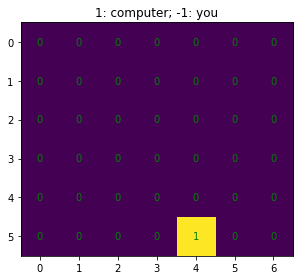

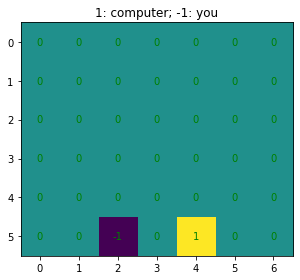

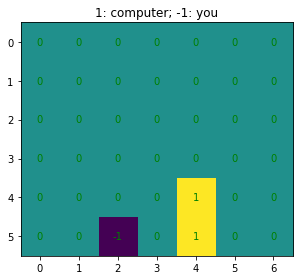

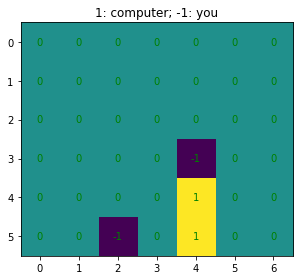

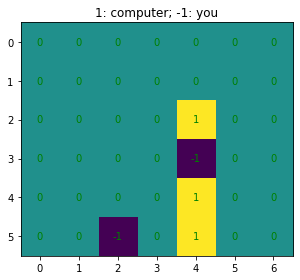

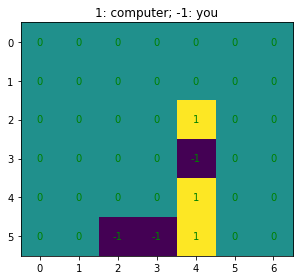

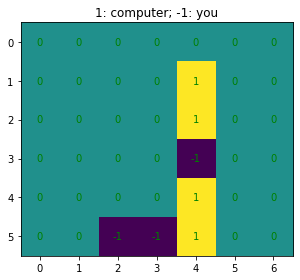

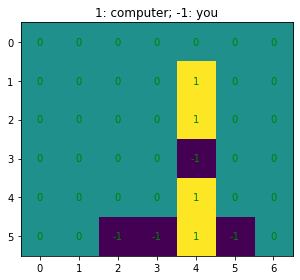

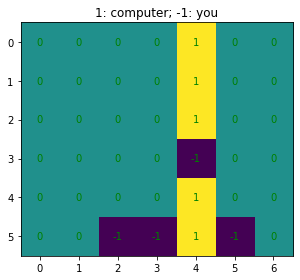

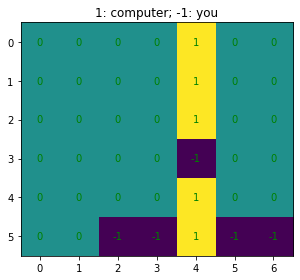

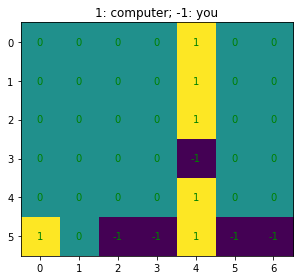

-1 wins


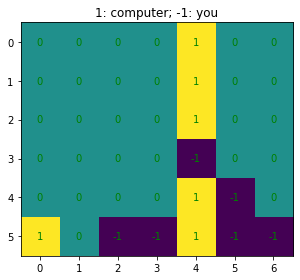

In [10]:
game.play_DQN(Q_target)

In [13]:
test1.play_game()

NameError: name 'test1' is not defined

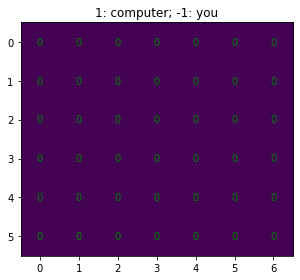

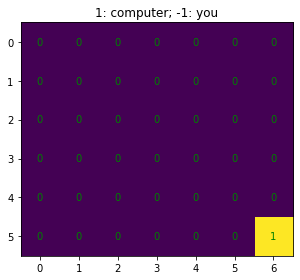

enter column: (0-6)
3


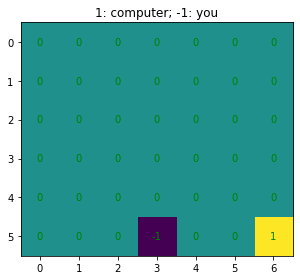

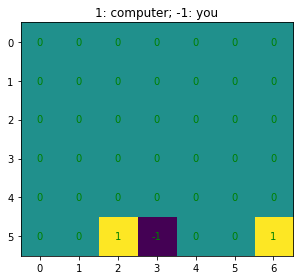

enter column: (0-6)
3


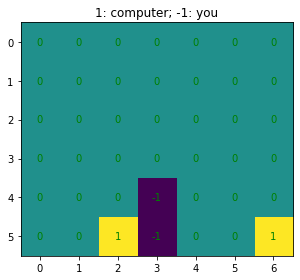

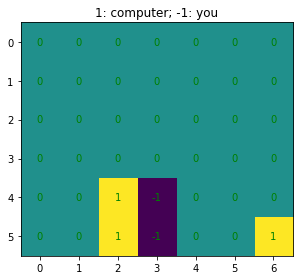

enter column: (0-6)
3


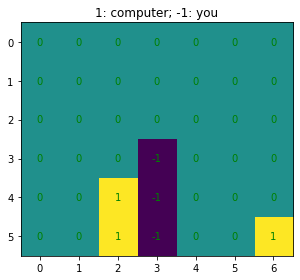

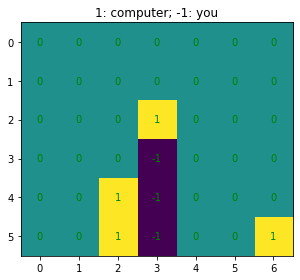

enter column: (0-6)
2


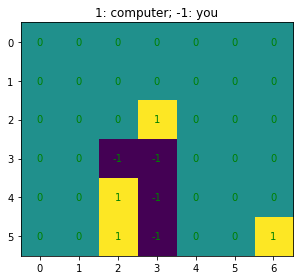

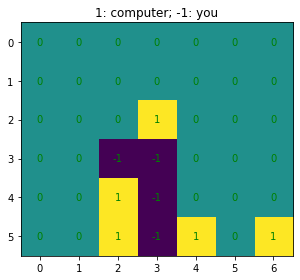

enter column: (0-6)
4


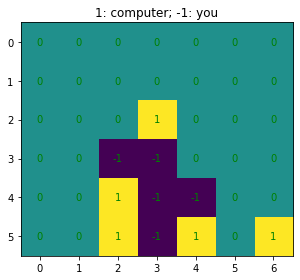

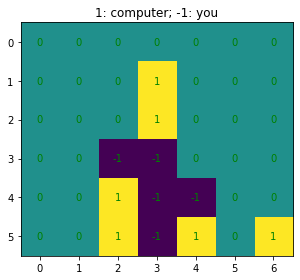

enter column: (0-6)
4


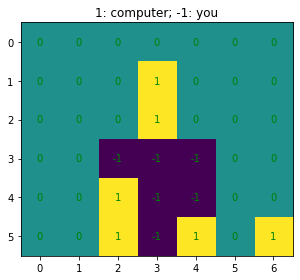

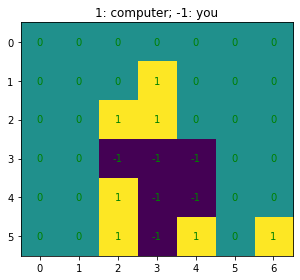

enter column: (0-6)
6


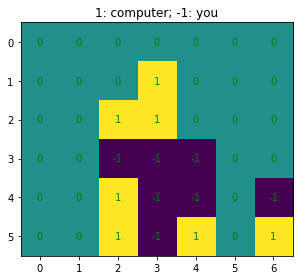

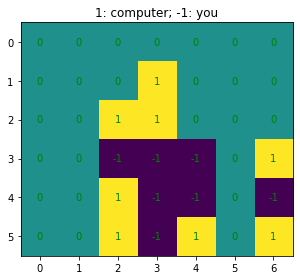

enter column: (0-6)
5


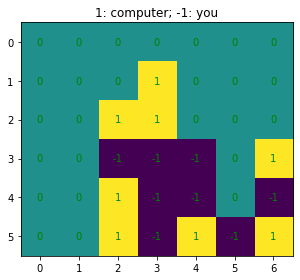

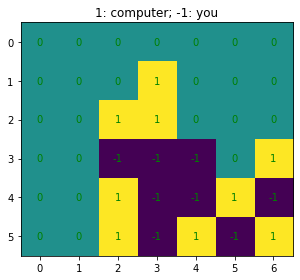

enter column: (0-6)
5


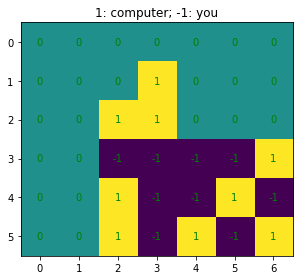

The winner is you


In [ ]:
test2 = connect4()
test2.play_game()

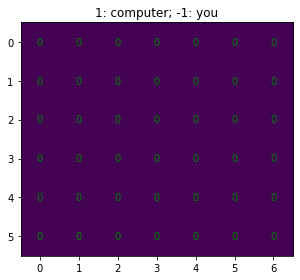

enter column: (0-6)
3


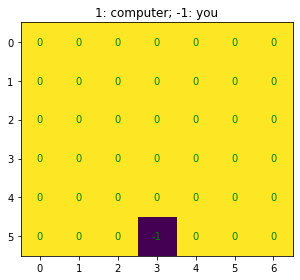

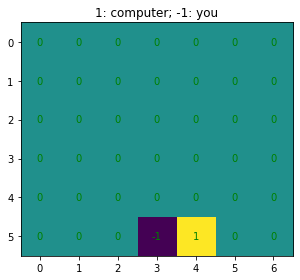

enter column: (0-6)
3


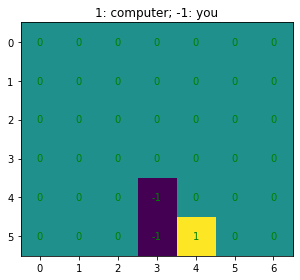

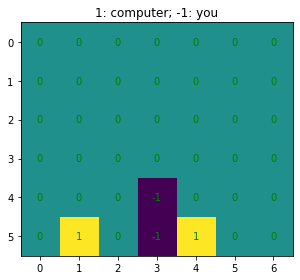

enter column: (0-6)
3


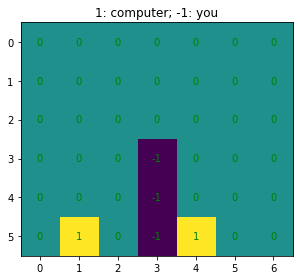

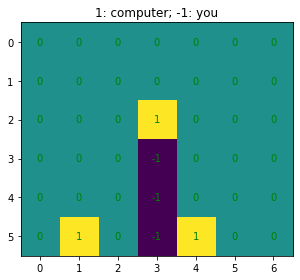

enter column: (0-6)
1


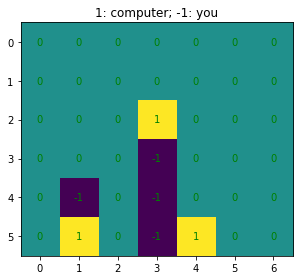

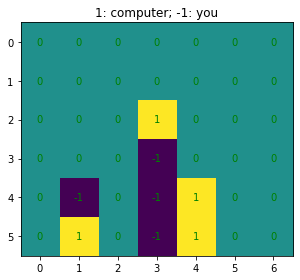

enter column: (0-6)
4


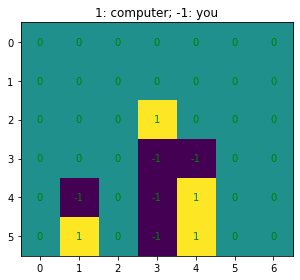

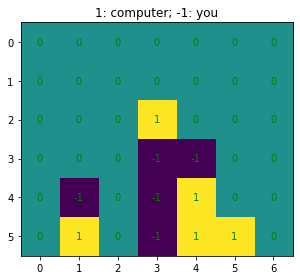

enter column: (0-6)
1


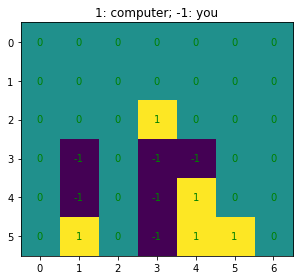

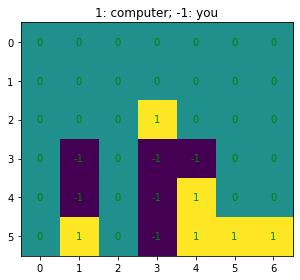

enter column: (0-6)
1


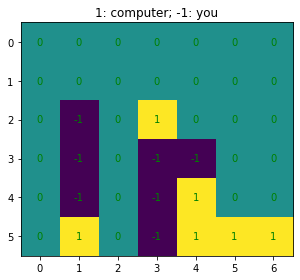

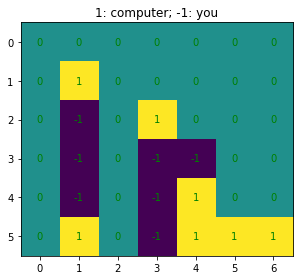

enter column: (0-6)
3


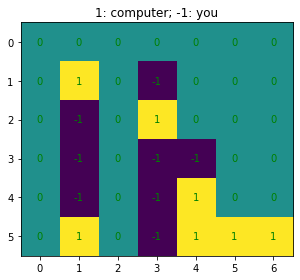

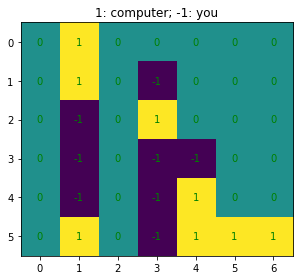

enter column: (0-6)
4


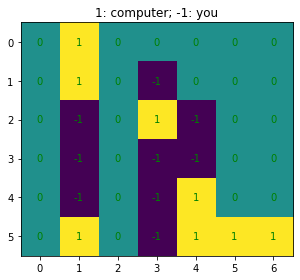

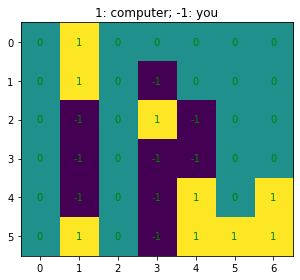

enter column: (0-6)
6


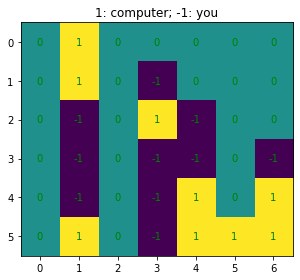

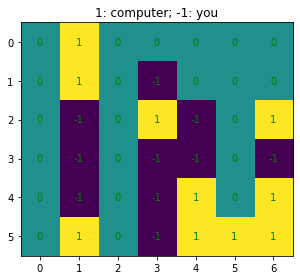

enter column: (0-6)
4


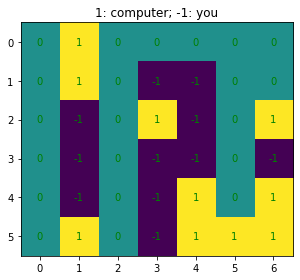

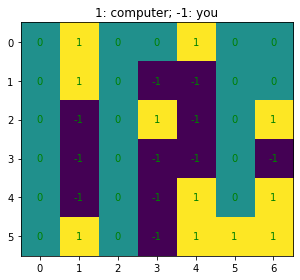

enter column: (0-6)
3


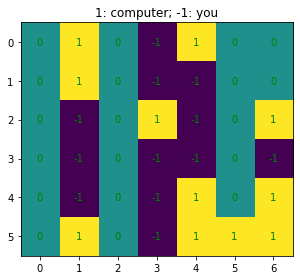

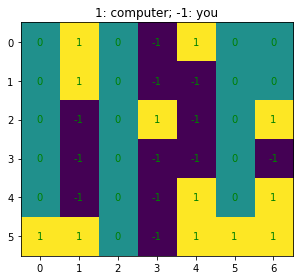

enter column: (0-6)
0


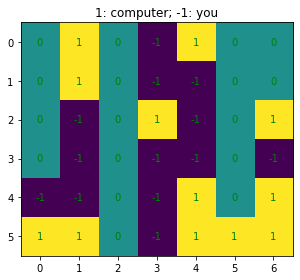

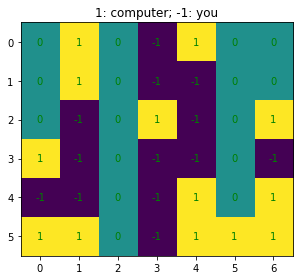

enter column: (0-6)
2


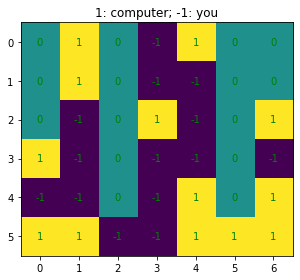

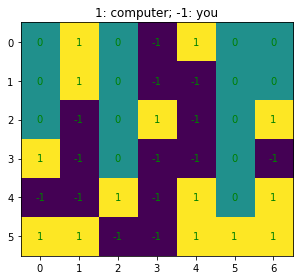

enter column: (0-6)
2


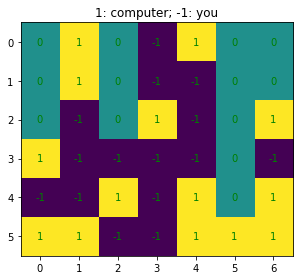

The winner is you


In [ ]:
test2 = connect4()
test2.play_game(starter = -1)

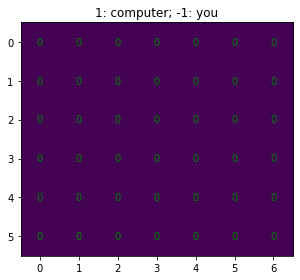

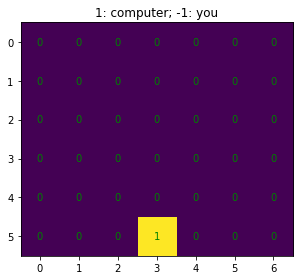

enter column: (0-6)
3


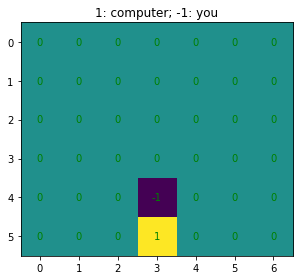

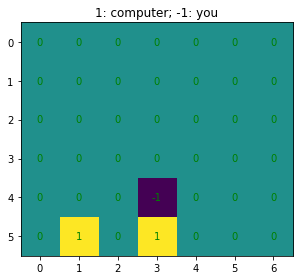

enter column: (0-6)
2


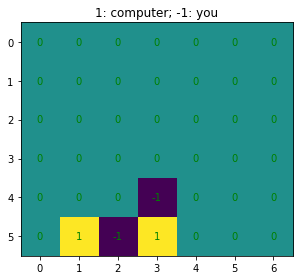

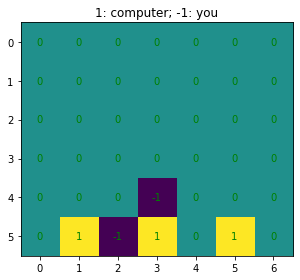

enter column: (0-6)
4


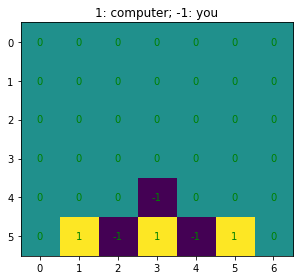

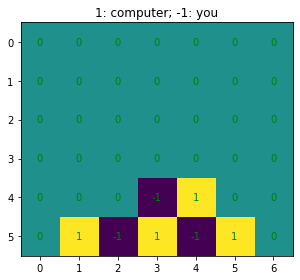

enter column: (0-6)
3


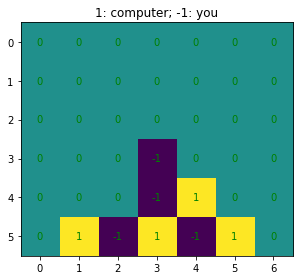

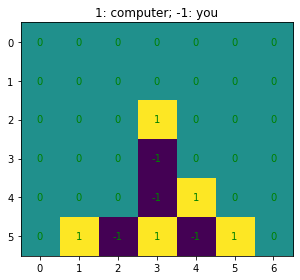

enter column: (0-6)
4


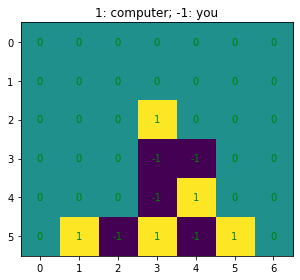

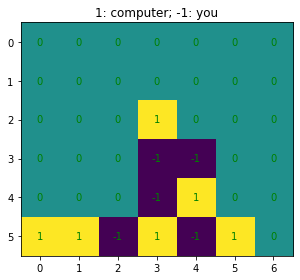

enter column: (0-6)
2


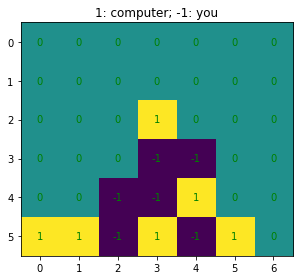

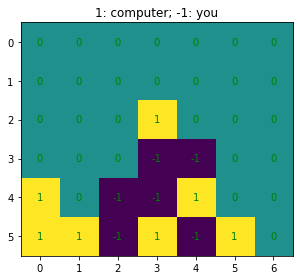

enter column: (0-6)
2


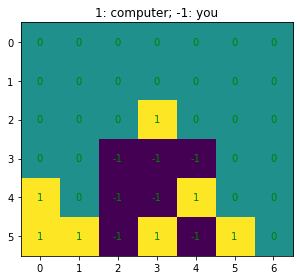

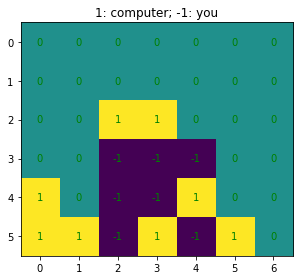

enter column: (0-6)
4


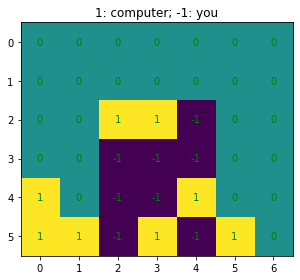

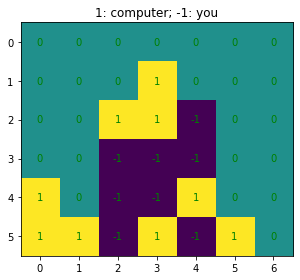

enter column: (0-6)
4


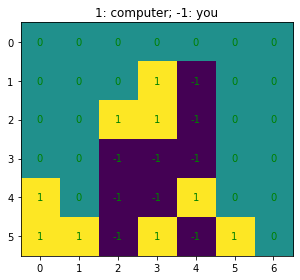

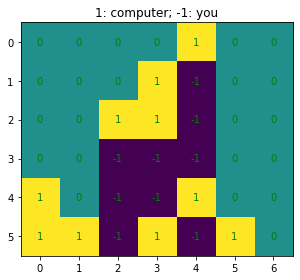

enter column: (0-6)
3


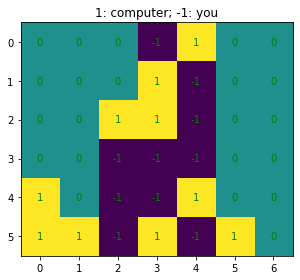

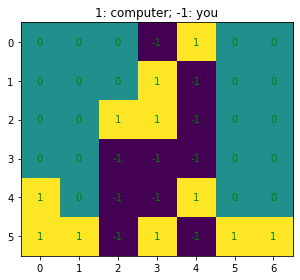

enter column: (0-6)
2


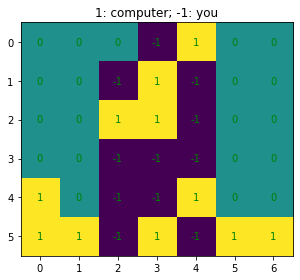

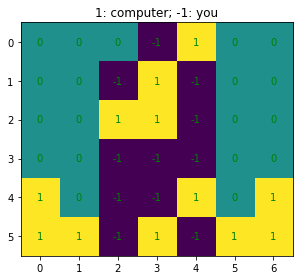

enter column: (0-6)
6


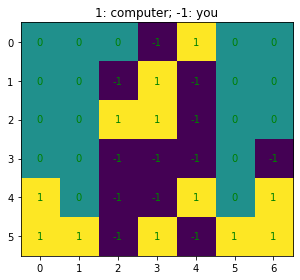

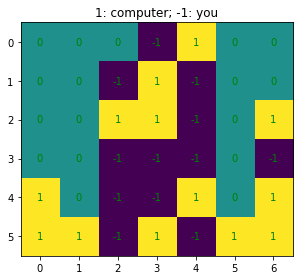

enter column: (0-6)
5


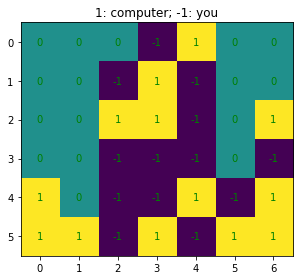

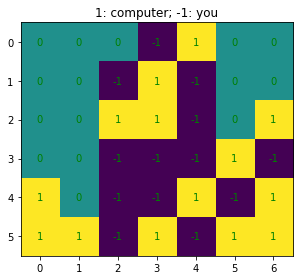

The winner is computer


In [ ]:
test3 = connect4()
test3.play_game()

In [ ]:
b = np.array([
        [ 0, -1,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  0,  0,  0,  0],
        [ 0, -1,  1,  0,  0,  0,  0],
        [ 0, -1,  1,  0,  0,  0,  0],
        [ 0,  1,  1,  1,  0,  0,  0]],)

a.ndim

2

In [ ]:
4 in np.count_nonzero(b == 1,axis = 0)

False

In [ ]:
np.diag(b)

array([ 0, -1,  0,  0,  0,  0])

In [ ]:
np.count_nonzero(np.diag(b) == 1)

0

In [ ]:
np.diagonal(b)

array([ 0, -1,  0,  0,  0,  0])

In [ ]:
# [np.diagonal(b,i) for i in range(-5,7)]
4 in [np.count_nonzero(array == 1) for array in [np.diagonal(np.fliplr(b),i) for i in range(-5,7)]]




False